### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

Hemos descargardo el traductor de Inglés-Español e Inglés-Catalán

In [29]:
data = read_text("traductores\spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

data = read_text("traductores\cat.txt")
cat_eng = to_lines(data)
cat_eng = array(cat_eng)

data = read_text("traductores\deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [30]:
spa_eng = spa_eng[:50000,:]
cat_eng = cat_eng[:50000,:]
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [31]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face.', 'Su cara mostraba fatiga.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name.',
        'Pocos estudiantes conocían su nombre.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire.', 'Rellena el cuestionario.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

In [32]:
cat_eng

array([['Wow!', 'Carai!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #5029086 (xenialf9)'],
       ['Really?', 'De veritat?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #373216 (kotobaboke) & #5029087 (xenialf9)'],
       ['Thanks.', 'Gràcies!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2057650 (nava) & #876068 (ziggsmith)'],
       ...,
       ["You can't park in a handicapped parking space unless you have a special permit.",
        "No pots aparcar a una plaça d'aparcament per discapacitats si no tens un permís especial.",
        'CC-BY 2.0 (France) Attribution: tatoeba.org #682271 (Source_VOA) & #876126 (ziggsmith)'],
       ["Drinking lots of water is good for you, sure, but one can't drink that much water at once.",
        'Beure molta aigua és bo per tu, segur, però no es pot beure tanta aigua de cop.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1528238 (marshmallowcat) & #1529321 (calogero)'],
       ["We're gonna ma

In [33]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['You need not go there.', 'Du musst nicht dorthin gehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['You need not go there.', 'Du brauchst nicht dorthin zu gehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['You need to apologize.', 'Du musst dich entschuldigen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [34]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

# Remove punctuation
cat_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in cat_eng[:,0]]
cat_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in cat_eng[:,1]]

# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [35]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face', 'Su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name',
        'Pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire', 'Rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

In [36]:
cat_eng

array([['Wow', 'Carai',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #5029086 (xenialf9)'],
       ['Really', 'De veritat',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #373216 (kotobaboke) & #5029087 (xenialf9)'],
       ['Thanks', 'Gràcies',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2057650 (nava) & #876068 (ziggsmith)'],
       ...,
       ['You cant park in a handicapped parking space unless you have a special permit',
        'No pots aparcar a una plaça daparcament per discapacitats si no tens un permís especial',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #682271 (Source_VOA) & #876126 (ziggsmith)'],
       ['Drinking lots of water is good for you sure but one cant drink that much water at once',
        'Beure molta aigua és bo per tu segur però no es pot beure tanta aigua de cop',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1528238 (marshmallowcat) & #1529321 (calogero)'],
       ['Were gonna make sure that no on

In [37]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['You need not go there', 'Du musst nicht dorthin gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['You need not go there', 'Du brauchst nicht dorthin zu gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['You need to apologize', 'Du musst dich entschuldigen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

In [38]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    spa_eng[i,1] = spa_eng[i,1].lower()
    
# convert to lowercase
for i in range(len(cat_eng)):
    cat_eng[i,0] = cat_eng[i,0].lower()
    cat_eng[i,1] = cat_eng[i,1].lower()
    
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

In [39]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['fatigue showed on her face', 'su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['few students knew his name',
        'pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['fill out the questionnaire', 'rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

In [40]:
cat_eng

array([['wow', 'carai',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #5029086 (xenialf9)'],
       ['really', 'de veritat',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #373216 (kotobaboke) & #5029087 (xenialf9)'],
       ['thanks', 'gràcies',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2057650 (nava) & #876068 (ziggsmith)'],
       ...,
       ['you cant park in a handicapped parking space unless you have a special permit',
        'no pots aparcar a una plaça daparcament per discapacitats si no tens un permís especial',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #682271 (Source_VOA) & #876126 (ziggsmith)'],
       ['drinking lots of water is good for you sure but one cant drink that much water at once',
        'beure molta aigua és bo per tu segur però no es pot beure tanta aigua de cop',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1528238 (marshmallowcat) & #1529321 (calogero)'],
       ['were gonna make sure that no on

In [41]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['you need not go there', 'du musst nicht dorthin gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['you need not go there', 'du brauchst nicht dorthin zu gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['you need to apologize', 'du musst dich entschuldigen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [42]:
# empty lists
eng_1 = []
spa_1 = []

eng_2 = []
cat_2 = []

eng_3 = []
deu_3 = []

###########################################
###########################################
###########################################

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_1.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_1.append(len(i.split()))

###########################################
###########################################
###########################################

# populate the lists with sentence lengths
for i in cat_eng[:,0]:
    eng_2.append(len(i.split()))

for i in cat_eng[:,1]:
    cat_2.append(len(i.split()))

###########################################
###########################################
###########################################
    
# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_3.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_3.append(len(i.split()))

In [52]:
length_df_eng_spa = pd.DataFrame({'eng':eng_1, 'spa':spa_1})
print(length_df_eng_spa)
print(max(length_df_eng_spa.eng))
print(max(length_df_eng_spa.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    4    4
49996    6    6
49997    5    4
49998    5    5
49999    4    3

[50000 rows x 2 columns]
8
12


In [53]:
length_df_eng_cat = pd.DataFrame({'eng':eng_2, 'cat':cat_2})
print(length_df_eng_cat)
print(max(length_df_eng_cat.eng))
print(max(length_df_eng_cat.cat))

     eng  cat
0      1    1
1      1    2
2      1    1
3      1    1
4      2    1
..   ...  ...
648   15   13
649   16   17
650   14   15
651   18   17
652   19   17

[653 rows x 2 columns]
19
17


In [54]:
length_df_eng_deu = pd.DataFrame({'eng':eng_3, 'deu':deu_3})
print(length_df_eng_deu)
print(max(length_df_eng_deu.eng))
print(max(length_df_eng_deu.deu))

       eng  deu
0        1    1
1        1    1
2        1    2
3        1    1
4        1    1
...    ...  ...
49995    4    5
49996    5    5
49997    5    5
49998    5    6
49999    4    4

[50000 rows x 2 columns]
7
15


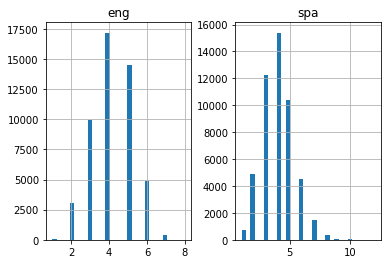

In [55]:
length_df_eng_spa.hist(bins = 30)
plt.show()

The maximum length of the spanish sentences is 10 and that of the English phrases is 8.

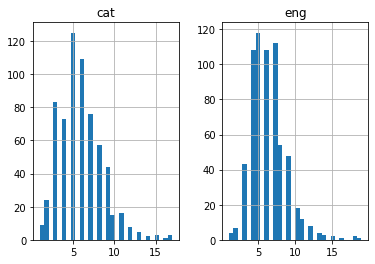

In [56]:
length_df_eng_cat.hist(bins = 30)
plt.show()

The maximum length of the Catalan sentences is 18 and that of the English phrases is 20.

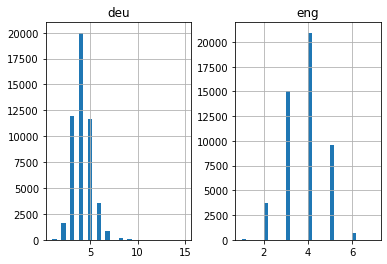

In [57]:
length_df_eng_deu.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [58]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [62]:
# prepare english tokenizer
eng_tokenizer_1 = tokenization(spa_eng[:, 0])
eng_vocab_size_1 = len(eng_tokenizer_1.word_index) + 1

eng_length_1 = 8
print('English Vocabulary Size: %d' % eng_vocab_size_1)

# prepare Spanish tokenizer
spa_tokenizer_1 = tokenization(spa_eng[:, 1])
spa_vocab_size_1 = len(spa_tokenizer_1.word_index) + 1

spa_length_1 = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size_1)

English Vocabulary Size: 6917
Spanish Vocabulary Size: 14176


In [66]:
# prepare english tokenizer
eng_tokenizer_2 = tokenization(cat_eng[:, 0])
eng_vocab_size_2 = len(eng_tokenizer_2.word_index) + 1

eng_length_2 = 8
print('English Vocabulary Size: %d' % eng_vocab_size_2)

# prepare Spanish tokenizer
cat_tokenizer_2 = tokenization(cat_eng[:, 1])
cat_vocab_size_2 = len(cat_tokenizer_2.word_index) + 1

cat_length_2 = 8
print('Catalan Vocabulary Size: %d' % cat_vocab_size_2)

English Vocabulary Size: 1002
Catalan Vocabulary Size: 1244


In [67]:
# prepare english tokenizer
eng_tokenizer_3 = tokenization(deu_eng[:, 0])
eng_vocab_size_3 = len(eng_tokenizer_3.word_index) + 1

eng_length_3 = 8
print('English Vocabulary Size: %d' % eng_vocab_size_3)

# prepare Spanish tokenizer
deu_tokenizer_3 = tokenization(deu_eng[:, 1])
deu_vocab_size_3 = len(deu_tokenizer_3.word_index) + 1

deu_length_3 = 8
print('Deutsch Vocabulary Size: %d' % deu_vocab_size_3)

English Vocabulary Size: 6331
Deutsch Vocabulary Size: 10455


In [70]:
print(spa_tokenizer_1.word_counts)

OrderedDict([('ve', 114), ('vete', 30), ('vaya', 39), ('váyase', 7), ('hola', 12), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 383), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 2), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 10), ('continúa', 14), ('continúe', 6), ('me', 3073), ('oculté', 1), ('escondí', 3), ('ocultaba', 1), ('escondía', 1), ('corrí', 13), ('corría', 4), ('lo', 2129), ('intento', 8), ('¡he', 2), ('ganado', 16), ('¡oh', 3), ('no', 5893), ('tomátelo', 2), ('con', 856), ('soda', 3), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 5), ('¡al', 2), ('ataque', 5), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 23), ('ahora', 505), ('mismo', 129), ('id', 7), ('vayan', 11), ('ya', 338), ('¡lo', 10), ('tengo', 883), ('¿lo', 63), ('pillas', 1), ('¿entendi

In [71]:
print(cat_tokenizer_2.word_counts)

OrderedDict([('carai', 1), ('de', 84), ('veritat', 3), ('gràcies', 5), ('adéu', 1), ('afanyat', 1), ('massa', 2), ('tard', 7), ('puc', 9), ('ajudar', 4), ('lenvejo', 1), ('testimo', 2), ('el', 114), ('temps', 5), ('vola', 1), ('jo', 15), ('també', 3), ('tinc', 22), ('17', 1), ('anys', 7), ('estic', 14), ('a', 99), ('casa', 5), ('demana', 1), ('un', 51), ('desig', 1), ('qui', 21), ('paga', 2), ('mana', 1), ('testimem', 1), ('us', 5), ('estimem', 1), ('ets', 6), ('tu', 9), ('és', 72), ('vostè', 2), ('sou', 3), ('vine', 2), ('amb', 33), ('nosaltres', 3), ('ell', 23), ('té', 14), ('gos', 3), ('ella', 21), ('es', 18), ('va', 66), ('aixecar', 2), ('hola', 1), ('tots', 13), ('desesperat', 1), ('deixam', 4), ('intentarho', 2), ('tens', 14), ('bona', 4), ('cara', 2), ('fas', 4), ('bon', 10), ('aspecte', 1), ('estàs', 6), ('boig', 1), ('any', 3), ('nou', 3), ('necessito', 1), ('segell', 1), ('vaig', 34), ('veure', 7), ('saltar', 1), ('en', 47), ('pau', 1), ('ho', 15), ('ha', 25), ('pintat', 1), 

In [72]:
print(deu_tokenizer_3.word_counts)

OrderedDict([('geh', 155), ('hallo', 34), ('grüß', 3), ('gott', 27), ('lauf', 9), ('potzdonner', 2), ('donnerwetter', 1), ('feuer', 23), ('hilfe', 131), ('zu', 2011), ('hülf', 1), ('stopp', 2), ('warte', 49), ('fang', 15), ('an', 870), ('mach', 199), ('weiter', 125), ('beeil', 11), ('dich', 1045), ('schnell', 178), ('ich', 11453), ('rannte', 48), ('verstehe', 48), ('aha', 2), ('probiere', 6), ('es', 4100), ('hab', 44), ('gewonnen', 70), ('habe', 2131), ('entspann', 6), ('schieß', 3), ('lächeln', 20), ('angriff', 3), ('attacke', 1), ('zum', 160), ('wohl', 53), ('iss', 27), ('auf', 1153), ('keine', 386), ('bewegung', 5), ('stehenbleiben', 2), ('verstanden', 24), ('habs', 9), ('kapiert', 2), ('einverstanden', 35), ('er', 2506), ('lief', 32), ('mit', 670), ('drück', 6), ('mich', 1634), ('nimm', 89), ('in', 861), ('den', 712), ('arm', 60), ('umarme', 2), ('fiel', 31), ('hin', 98), ('stürzte', 6), ('bin', 1878), ('hingefallen', 1), ('gestürzt', 1), ('weiß', 389), ('gelogen', 33), ('verloren'

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [73]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

<bound method Tokenizer.texts_to_sequences of <keras_preprocessing.text.Tokenizer object at 0x000001D5AD17AA08>>


### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [74]:
from sklearn.model_selection import train_test_split
train_spa, test_spa = train_test_split(spa_eng, test_size=0.2, random_state = 12)
train_cat, test_cat = train_test_split(cat_eng, test_size=0.2, random_state = 12)
train_deu, test_deu = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [76]:
# prepare training data
trainX_spa = encode_sequences(spa_tokenizer_1, spa_length_1, train_spa[:, 1])
trainY_spa = encode_sequences(eng_tokenizer_1, eng_length_1, train_spa[:, 0])

# prepare training data
trainX_cat = encode_sequences(cat_tokenizer_2, cat_length_2, train_cat[:, 1])
trainY_cat = encode_sequences(eng_tokenizer_2, eng_length_2, train_cat[:, 0])

# prepare training data
trainX_deu = encode_sequences(deu_tokenizer_3, deu_length_3, train_deu[:, 1])
trainY_deu = encode_sequences(eng_tokenizer_3, eng_length_3, train_deu[:, 0])

[[   1    2  969 ...   33    0    0]
 [  11   13  728 ... 2951    0    0]
 [  30  486   14 ...  231    0    0]
 ...
 [  10 3406    7 ...    0    0    0]
 [4520   14   40 ... 1504    0    0]
 [  81  381  250 ...    0    0    0]]
40000
[[   3  487   67 ...    0    0    0]
 [   9  327   43 ...    0    0    0]
 [   1   17   70 ...   50    0    0]
 ...
 [   2  327   13 ...    0    0    0]
 [1224  123  755 ...   25    0    0]
 [   1   50    7 ...    0    0    0]]
40000
[[  41  407  332 ...   10  181    0]
 [   1   39   40 ...    0    0    0]
 [  40    6  226 ... 1051    0    0]
 ...
 [  41  329    1 ...    0    0    0]
 [ 277  133   16 ...    0    0    0]
 [  14  777  778 ...  279  779    0]]
522
[[ 20 431  34 ...  19   5 224]
 [  1  64  87 ...   0   0   0]
 [118 166   3 ...  14 131 459]
 ...
 [ 20 254 140 ... 161   0   0]
 [  4 196  28 ...   0   0   0]
 [682 683   8 ...   0   0   0]]
522
[[   1  109    5 ...    0    0    0]
 [   9    1 1705 ...    0    0    0]
 [   7    3   93 ...    0    0

In [78]:
print("-------- SPANISH --------")
print(trainX_spa.shape)
print(trainY_spa.shape)
print("-------- CATALAN --------")
print(trainX_cat.shape)
print(trainY_cat.shape)
print("-------- DEUTSCH --------")
print(trainX_deu.shape)
print(trainY_deu.shape)

-------- SPANISH --------
(40000, 8)
(40000, 8)
-------- CATALAN --------
(522, 8)
(522, 8)
-------- DEUTSCH --------
(40000, 8)
(40000, 8)


In [79]:
# prepare validation data
testX_spa = encode_sequences(spa_tokenizer_1, spa_length_1, test_spa[:, 1])
testY_spa = encode_sequences(eng_tokenizer_1, eng_length_1, test_spa[:, 0])

# prepare validation data
testX_cat = encode_sequences(cat_tokenizer_2, cat_length_2, test_cat[:, 1])
testY_cat = encode_sequences(eng_tokenizer_2, eng_length_2, test_cat[:, 0])

# prepare validation data
testX_deu = encode_sequences(deu_tokenizer_3, deu_length_3, test_deu[:, 1])
testY_deu = encode_sequences(eng_tokenizer_3, eng_length_3, test_deu[:, 0])


[[1053   84 1197 ...    0    0    0]
 [  22   78   29 ...    0    0    0]
 [  70   20  832 ...    0    0    0]
 ...
 [1267  141   25 ...    0    0    0]
 [  38  240    6 ...    0    0    0]
 [   3  295  157 ...    0    0    0]]
10000
[[ 81  51  34 ...   0   0   0]
 [  1 108  38 ...   0   0   0]
 [ 71 532   2 ...   0   0   0]
 ...
 [ 11   2  26 ...   0   0   0]
 [  2  17 629 ...   0   0   0]
 [  9   4 224 ...   0   0   0]]
10000
[[  11   10  176 ...   28 1229  236]
 [ 359    6    3 ...    8   19  402]
 [  25  264  452 ...    0    0    0]
 ...
 [   3   67  116 ...  533    0    0]
 [   6    3   85 ...  272  138   66]
 [ 420 1106  406 ...    0    0    0]]
131
[[165   7 112 ... 149  19 172]
 [181   6  48 ...  65   3 427]
 [ 99 474   0 ...   0   0   0]
 ...
 [ 29 537  22 ...   0   0   0]
 [949  42  53 ... 126  84  23]
 [ 80  11 463 ...  23 903 430]]
131
[[   1 2074   27 ...    0    0    0]
 [  11    3 2921 ...    0    0    0]
 [   2   55 3669 ...    0    0    0]
 ...
 [1021    4   56 ...    

In [80]:
print("-------- SPANISH --------")
print(testX_spa.shape)
print(testY_spa.shape)
print("-------- CATALAN --------")
print(testX_cat.shape)
print(testY_cat.shape)
print("-------- DEUTSCH --------")
print(testX_deu.shape)
print(testY_deu.shape)

-------- SPANISH --------
(10000, 8)
(10000, 8)
-------- CATALAN --------
(131, 8)
(131, 8)
-------- DEUTSCH --------
(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [81]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [84]:
print("-------- SPANISH --------")
print(spa_vocab_size_1)
print(eng_vocab_size_1)
print(spa_length_1)
print(eng_length_1)
print("-------- CATALAN --------")
print(cat_vocab_size_2)
print(eng_vocab_size_2)
print(cat_length_2)
print(eng_length_2)
print("-------- DEUTSCH --------")
print(deu_vocab_size_3)
print(eng_vocab_size_3)
print(deu_length_3)
print(eng_length_3)

-------- SPANISH --------
14176
6917
8
8
-------- CATALAN --------
1244
1002
8
8
-------- DEUTSCH --------
10455
6331
8
8


In [94]:
print("-------- SPANISH --------")
model_spa = build_model(spa_vocab_size_1, eng_vocab_size_1, spa_length_1, eng_length_1, 512)
rms_spa = optimizers.RMSprop(lr=0.001)
model_spa.compile(optimizer=rms_spa, loss='sparse_categorical_crossentropy')

print("-------- CATALAN --------")
model_cat = build_model(cat_vocab_size_2, eng_vocab_size_2, cat_length_2, eng_length_2, 512)
rms_cat = optimizers.RMSprop(lr=0.001)
model_cat.compile(optimizer=rms_cat, loss='sparse_categorical_crossentropy')

print("-------- DEUTSCH --------")
model_deu = build_model(deu_vocab_size_3, eng_vocab_size_3, deu_length_3, eng_length_3, 512)
rms = optimizers.RMSprop(lr=0.001)
model_deu.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

-------- SPANISH --------
-------- CATALAN --------
-------- DEUTSCH --------


Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [89]:
filename = 'model_spa.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_spa = model_spa.fit(trainX_spa, trainY_spa.reshape(trainY_spa.shape[0], trainY_spa.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 5s 162us/step - loss: 1.7873 - val_loss: 2.1979

Epoch 00001: val_loss improved from inf to 2.19786, saving model to model_spa.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 5s 161us/step - loss: 1.6935 - val_loss: 2.1304

Epoch 00002: val_loss improved from 2.19786 to 2.13043, saving model to model_spa.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 5s 161us/step - loss: 1.6004 - val_loss: 2.0739

Epoch 00003: val_loss improved from 2.13043 to 2.07389, saving model to model_spa.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 5s 162us/step - loss: 1.5149 - val_loss: 2.0476

Epoch 00004: val_loss improved from 2.07389 to 2.04756, saving model to model_spa.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 5s 163us/step - loss: 1.4315 - val_loss: 2.0118

Epoch 00005: val_loss improved from 2.04

In [90]:
filename = 'model_cat.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_cat = model_cat.fit(trainX_cat, trainY_cat.reshape(trainY_cat.shape[0], trainY_cat.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

C:\Users\carra\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 417 samples, validate on 105 samples
Epoch 1/30
417/417 [==============================] - 1s 1ms/step - loss: 6.9097 - val_loss: 6.8763

Epoch 00001: val_loss improved from inf to 6.87632, saving model to model_cat.h1.24_jan_19
Epoch 2/30
417/417 [==============================] - 0s 93us/step - loss: 6.8687 - val_loss: 6.2290

Epoch 00002: val_loss improved from 6.87632 to 6.22901, saving model to model_cat.h1.24_jan_19
Epoch 3/30
417/417 [==============================] - 0s 127us/step - loss: 6.0869 - val_loss: 7.8658

Epoch 00003: val_loss did not improve from 6.22901
Epoch 4/30
417/417 [==============================] - 0s 108us/step - loss: 7.8004 - val_loss: 5.5617

Epoch 00004: val_loss improved from 6.22901 to 5.56168, saving model to model_cat.h1.24_jan_19
Epoch 5/30
417/417 [==============================] - 0s 120us/step - loss: 5.3203 - val_loss: 5.5184

Epoch 00005: val_loss improved from 5.56168 to 5.51838, saving model to model_cat.h1.24_jan_19
Epoch 6/30
417/

In [95]:
filename = 'model_deu.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_deu = model_deu.fit(trainX_deu, trainY_deu.reshape(trainY_deu.shape[0], trainY_deu.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

C:\Users\carra\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 5s 171us/step - loss: 3.4378 - val_loss: 2.8900

Epoch 00001: val_loss improved from inf to 2.89001, saving model to model_deu.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 5s 156us/step - loss: 2.8128 - val_loss: 2.7772

Epoch 00002: val_loss improved from 2.89001 to 2.77717, saving model to model_deu.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 5s 156us/step - loss: 2.6451 - val_loss: 2.6065

Epoch 00003: val_loss improved from 2.77717 to 2.60647, saving model to model_deu.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 5s 156us/step - loss: 2.4649 - val_loss: 2.4676

Epoch 00004: val_loss improved from 2.60647 to 2.46758, saving model to model_deu.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 5s 156us/step - loss: 2.3241 - val_loss: 2.3765

Epoch 00005: val_loss improved from 2.46

Let's compare the training loss and the validation loss.

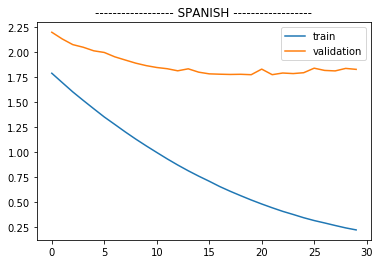

In [96]:
plt.plot(history_spa.history['loss'])
plt.plot(history_spa.history['val_loss'])
plt.title('------------------ SPANISH ------------------')
plt.legend(['train','validation'])
plt.show()

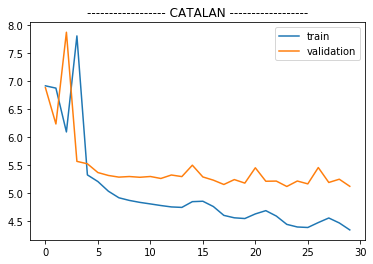

In [98]:
plt.plot(history_cat.history['loss'])
plt.plot(history_cat.history['val_loss'])
plt.title('------------------ CATALAN ------------------')
plt.legend(['train','validation'])
plt.show()

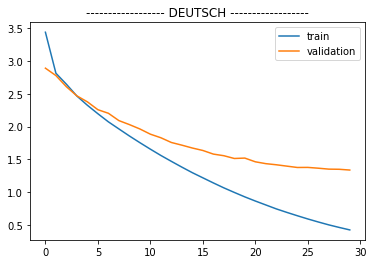

In [99]:
plt.plot(history_deu.history['loss'])
plt.plot(history_deu.history['val_loss'])
plt.title('------------------ DEUTSCH ------------------')
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [101]:
model_spa = load_model('model_spa.h1.24_jan_19')
model_cat = load_model('model_cat.h1.24_jan_19')
model_deu = load_model('model_deu.h1.24_jan_19')

C:\Users\carra\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\carra\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\carra\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [106]:
print('------------------ SPANISH PREDICTED ------------------')
preds_spa = model_spa.predict_classes(testX_spa.reshape((testX_spa.shape[0],testX_spa.shape[1])))
print('------------------ CATALAN PREDICTED ------------------')
preds_cat = model_cat.predict_classes(testX_cat.reshape((testX_cat.shape[0],testX_cat.shape[1])))
print('------------------ DEUTSCH PREDICTED ------------------')
preds_deu = model_deu.predict_classes(testX_deu.reshape((testX_deu.shape[0],testX_deu.shape[1])))

------------------ SPANISH PREDICTED ------------------
------------------ CATALAN PREDICTED ------------------
------------------ DEUTSCH PREDICTED ------------------


In [107]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [108]:
# convert predictions SPANISH into text (English)
preds_text_spa = []
for i in preds_spa:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer_1)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer_1)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text_spa.append(' '.join(temp))

In [109]:
# convert predictions CATALAN into text (English)
preds_text_cat = []
for i in preds_cat:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer_2)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer_2)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text_cat.append(' '.join(temp))

In [110]:
# convert predictions DEUTSCH into text (English)
preds_text_deu = []
for i in preds_deu:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer_3)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer_3)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text_deu.append(' '.join(temp))

In [113]:
pred_df_spa = pd.DataFrame({'actual' : test_spa[:,0], 'predicted' : preds_text_spa})
pred_df_cat = pd.DataFrame({'actual' : test_cat[:,0], 'predicted' : preds_text_cat})
pred_df_deu = pd.DataFrame({'actual' : test_deu[:,0], 'predicted' : preds_text_deu})

In [114]:
pd.set_option('display.max_colwidth', 200)

In [118]:
print('------------------ SPANISH PREDICTED ------------------')
pred_df_spa.head(15)

------------------ SPANISH PREDICTED ------------------


,actual,predicted
0,so how did this happen,how does did do
1,i eat here,i get here
2,who helped you,who helped you
3,smoke appeared,he made up rain
4,they went to new zealand,they went to food
5,can you explain it to me,can you explain it to me
6,four times five is twenty,four plus five is twenty
7,i just wanted to see you,i just want to see you
8,im a little crazy,im am little
9,im sorry for what i did,i sorry what you


In [119]:
pred_df_spa.tail(15)

,actual,predicted
9985,you really are nuts,youre sure youre you
9986,they kept running,they left
9987,all of these are mine,all are mine
9988,youve come too early,youve went very early
9989,nobody can stop tom,no one stop anyone
9990,i dont mind waiting,i dont not care for
9991,happy thanksgiving,a of are
9992,i loved her,i loved him
9993,did you come here alone,have you come here soon
9994,were surrounded,theyre impatient


In [120]:
print('------------------ CATALAN PREDICTED ------------------')
pred_df_cat.head(15)

------------------ CATALAN PREDICTED ------------------


,actual,predicted
0,my friend has had three jobs in a year he never sticks to anything for long,i the
1,night is when most people go to bed,i the
2,money talks,i
3,i can repeat it again and again,i
4,it is said that golf is very popular in japan,i the
5,i dont know if he knows it,i
6,is there a post office around here,i the
7,i believe the choice is clear,i
8,the earth is much larger than the moon,i to
9,its always been that way,i


In [121]:
pred_df_cat.tail(15)

,actual,predicted
116,the girl didnt say anything,i
117,the bus arrived ten minutes late,i
118,tom may talk to mary if he wants to,i the
119,the bus arrived ten minutes late,i
120,what you think is irrelevant,i
121,this medicine must not be placed within the reach of children,i the
122,my dog has a very long tail,i the
123,we love you,i
124,cuzco is one of the most interesting places in the world,i the
125,i cant remember which is my racket,i the


In [122]:
print('------------------ DEUTSCH PREDICTED ------------------')
pred_df_deu.head(15)

------------------ DEUTSCH PREDICTED ------------------


,actual,predicted
0,tom banged his head,tom washed his hair
1,he is a dj,he is a
2,i like seafood,i like candlelight
3,do it tomorrow,turn it
4,do you need the phone,do you need the phone
5,this door wont shut,the door wont open
6,i think youre stupid,i think youre so
7,toms wife just died,toms man did toms
8,tom kept winning,tom kept his
9,who do you live with,who are you going of


In [123]:
pred_df_deu.tail(15)

,actual,predicted
9985,we should be fine,we should go up
9986,i had a bad cold,i had a bad cold
9987,that might be true,it may be true
9988,i dont sleep a lot,i dont like much
9989,the price is good,the soup is good
9990,come back tomorrow,come again tomorrow
9991,superman can fly,can
9992,go find out,go and see
9993,your feet are dirty,your hands are dirty
9994,tom is immobile,tom is
